In [1]:
import os
import re
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())

    if len(images) < num_images:
        raise ValueError(f"Requested {num_images} images, but only {len(images)} available.")
    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    
    plt.tight_layout()
    plt.show()

def plot_training_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_results(model, dataloader, tokenizer, num_images=5):
    for images, _ in dataloader:
        images = images[:num_images].to(device)
        captions = [generate_caption(model, image, tokenizer) for image in images]

        plt.figure(figsize=(5, num_images * 5))

        for i in range(num_images):
            ax = plt.subplot(num_images, 1, i + 1)
            ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            ax.axis("off")  # Remove axes
            ax.set_title(captions[i], fontsize=12, wrap=True)

        plt.tight_layout()
        plt.show()
        break

# def display_random_images_with_captions(images_dir, captions_dict, num_images=5):
#     selected_images = random.sample(list(captions_dict.keys()), num_images)
#     plt.figure(figsize=(15, 10))

#     for i, image_id in enumerate(selected_images):
#         img_path = f"{images_dir}/{image_id}"
#         img = Image.open(img_path)

#         plt.subplot(num_images, 1, i + 1)
#         # plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(captions_dict[image_id], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()
        
def plot_caption_length_variation(captions_dict):
    lengths = []
    for captions in captions_dict.values():
        lengths.extend([len(caption.split()) for caption in captions])
    
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(lengths)), lengths, alpha=0.5)
    plt.title("Variation in Caption Lengths", fontsize=14)
    plt.xlabel("Caption Index", fontsize=12)
    plt.ylabel("Caption Length (Number of Words)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_word_frequency_histogram(captions_dict, top_n=20):
    word_counter = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            word_counter.update(preprocessed_caption.split())
    
    most_common_words = word_counter.most_common(top_n)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {top_n} Most Frequent Words", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

In [4]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

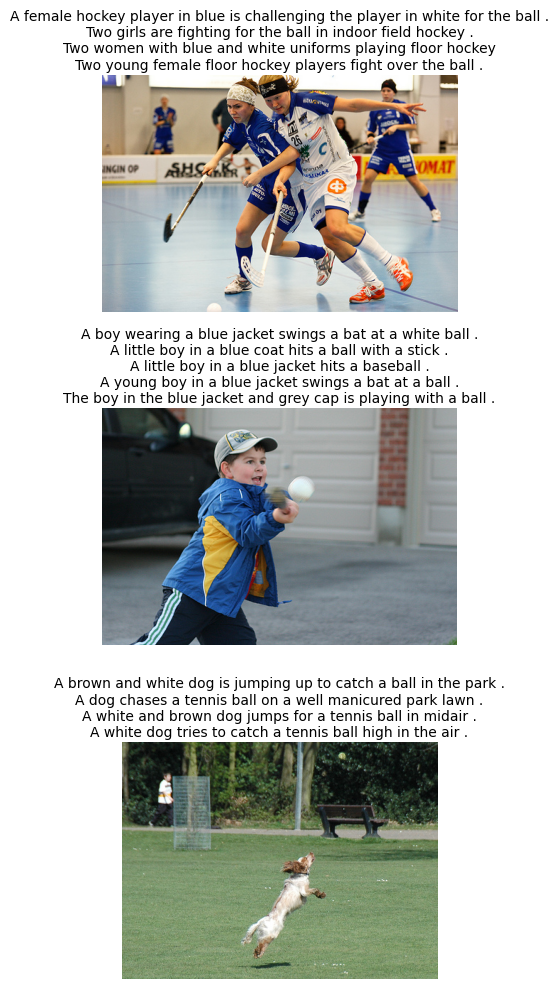

In [5]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    return text.strip()

def build_tokenizer(captions_dict):
    special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    word_to_index = defaultdict(lambda: special_tokens["<unk>"], special_tokens.copy())
    
    # Tokenize captions and build vocabulary
    vocab = set()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            vocab.update(preprocessed_caption.split())
    
    # Add vocabulary words to the tokenizer
    for idx, word in enumerate(sorted(vocab), start=len(special_tokens)):
        word_to_index[word] = idx
    
    return dict(word_to_index)

def save_tokenizer_to_json(tokenizer, filepath):
    with open(filepath, 'w') as file:
        json.dump(tokenizer, file, ensure_ascii=False, indent=4)

def caption_tokenizer(caption, word_to_index, max_length=50): # //TODO::WTF::
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    token_ids = token_ids[:max_length]
    token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    return torch.tensor(token_ids)

In [7]:
word_to_index_tokenizer = build_tokenizer(captions_dict)

TOKENIZER_FILE = "tokenizer.json"
save_tokenizer_to_json(word_to_index_tokenizer, TOKENIZER_FILE)

print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_tokenizer)}")

Word to Index Tokenizer saved to tokenizer.json. Total tokens: 8478


In [8]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [9]:
# display_random_images_with_captions(IMAGES_DIR, captions_dict, num_images=5)

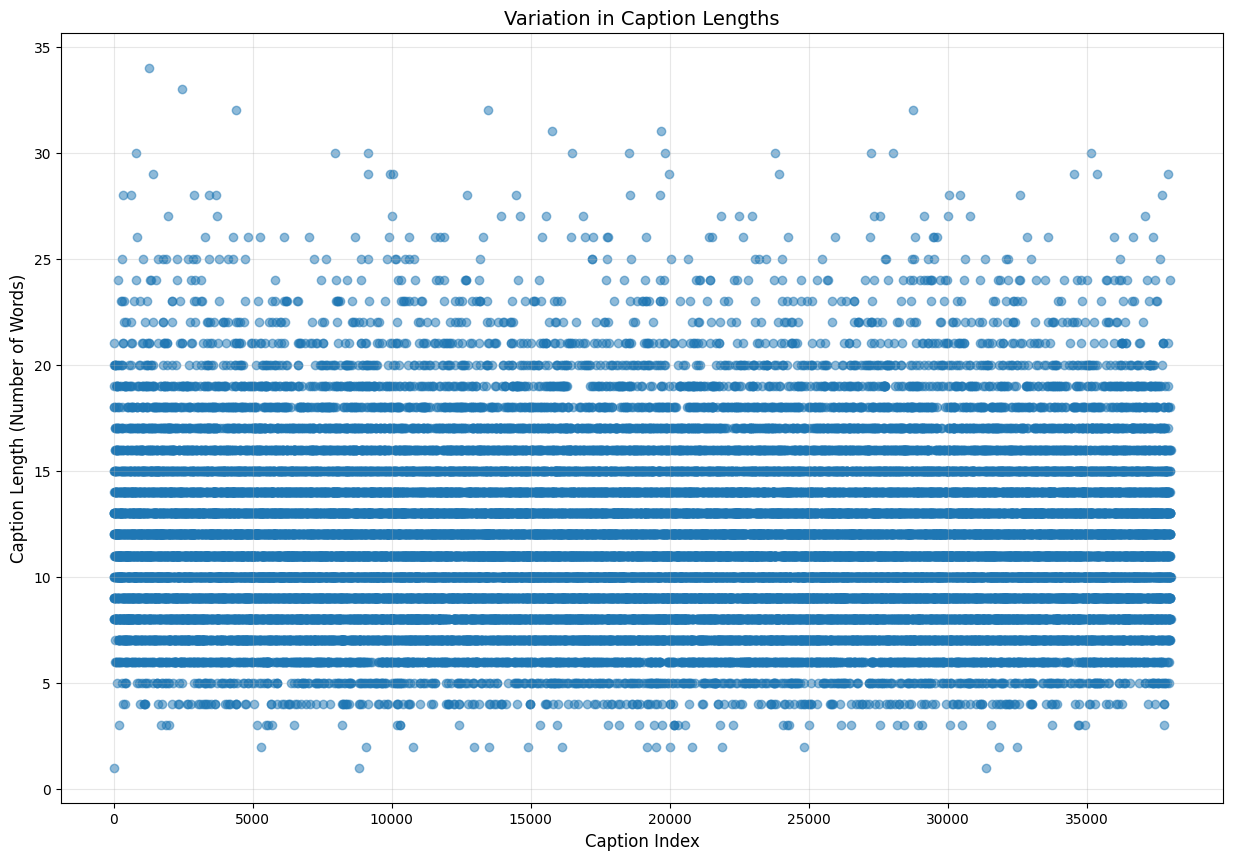

In [10]:
plot_caption_length_variation(captions_dict)

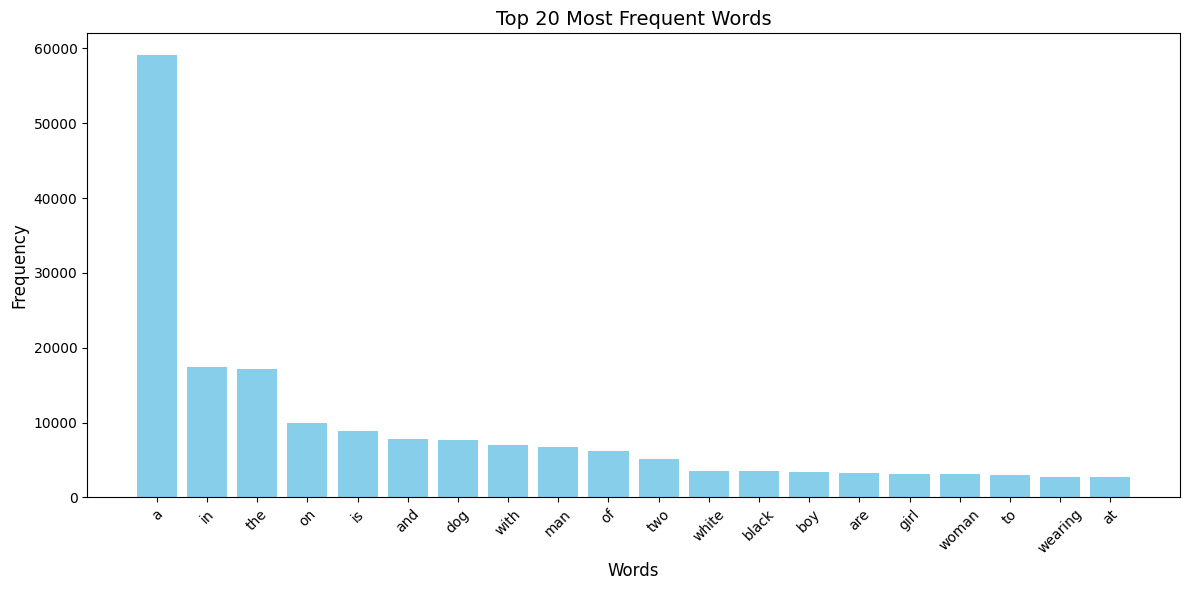

In [11]:
plot_word_frequency_histogram(captions_dict, top_n=20)

In [12]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)

        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if os.path.exists(image_path):
                for caption in captions:
                    self.image_caption_pairs.append((image_id, caption))
        
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            caption = self.tokenizer(caption)

        return image, caption

def create_dataloaders(images_dir, train_captions_file, val_captions_file, test_captions_file, batch_size, tokenizer):
    transform_train = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = FlickrDataset(train_captions_file, images_dir, transform=transform_train, tokenizer=tokenizer)
    val_dataset = FlickrDataset(val_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    test_dataset = FlickrDataset(test_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [13]:
with open(TOKENIZER_FILE, "r") as file:
    word_to_index = json.load(file)

train_loader, val_loader, test_loader = create_dataloaders(
    IMAGES_DIR,
    "train_captions.json",
    "val_captions.json",
    "test_captions.json",
    BATCH_SIZE,
    lambda caption: caption_tokenizer(caption, word_to_index)
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 476
Validation batches: 60
Testing batches: 60


In [14]:
PAD_IDX = word_to_index_tokenizer["<pad>"]

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size):
        super(EncoderCNN, self).__init__()
        self.efficient_net = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficient_net.classifier = nn.Identity()
        self.features = self.efficient_net.features
        self.fc = nn.Linear(1280, encoded_image_size)

    def forward(self, images):
        features = self.features(images)  # (batch_size, 1280, H, W)
        batch_size, channels, height, width = features.size()
        features = features.permute(0, 2, 3, 1).reshape(batch_size, -1, channels)  # (batch_size, H*W, channels)
        features = self.fc(features)  # (batch_size, H*W, encoded_image_size)
        return features


class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Encoder attention
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Decoder attention
        self.full_att = nn.Linear(attention_dim, 1)  # Combine both attentions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Normalize weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # Attention weights
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # Weighted sum of encoder outputs
        return context, alpha

class DecoderRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5, max_length=50):
        super(DecoderRNN, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding layer
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # LSTM cell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Initialize hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Initialize cell state
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # Gate for context vector
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # Final output layer
        self.dropout = nn.Dropout(p=dropout)
        self.max_length = max_length  # Maximum caption length

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # Hidden state
        c = self.init_c(mean_encoder_out)  # Cell state
        return h, c

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        encoder_out = encoder_out.view(batch_size, -1, encoder_out.size(-1)) # Flatten encoder output
        num_pixels = encoder_out.size(1)
        h, c = self.init_hidden_state(encoder_out)
        embeddings = self.embedding(captions)
        predictions = torch.zeros(batch_size, captions.size(1), vocab_size).to(encoder_out.device)
        # predictions = torch.zeros(batch_size, self.max_length, vocab_size).to(encoder_out.device)
        # alphas = torch.zeros(batch_size, self.max_length, num_pixels).to(encoder_out.device)
        alphas = torch.zeros(batch_size, captions.size(1), num_pixels).to(encoder_out.device)
        for t in range(captions.size(1)): # self.max_length
            context, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # Gated context vector
            context = gate * context
            h, c = self.decode_step(
                torch.cat([embeddings[:, t, :], context], dim=1),
                (h, c)
            )
            preds = self.fc(self.dropout(h))  # Compute predictions
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha

        return predictions, alphas

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)  # Extract image features
        outputs, alphas = self.decoder(features, captions)  # Generate captions
        # Use alphas to visualize attention
        self.visualize_attention(alphas, images)
        return outputs, alphas

    @staticmethod
    def visualize_attention(alphas, images):
        alphas = alphas.cpu().detach().numpy()  # Convert to NumPy
        images = images.cpu().detach().numpy()

        for i, alpha in enumerate(alphas):
            for t in range(alpha.shape[0]):
                attention = alpha[t].reshape(7, 7)  # Assuming 7x7 spatial resolution
                plt.imshow(images[i].transpose(1, 2, 0))  # Convert CHW to HWC
                plt.imshow(attention, cmap='jet', alpha=0.6)  # Overlay attention
                plt.title(f'Time step {t}')
                plt.show()

In [22]:
def masked_cross_entropy_loss(outputs, targets):
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    return loss_fn(outputs.permute(0, 2, 1), targets)  # Permute for [batch_size, vocab_size, seq_len]

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path="checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer): # //TODO::WTF:: I don't know how to use till no.
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, loss

def generate_caption(model, image, tokenizer, max_length=20):
    model.eval() 

    index_to_word = {index: word for word, index in tokenizer.items()}
    start_token = tokenizer["<sos>"]
    end_token = tokenizer["<eos>"]

    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))

        caption = [start_token]  # Begin with <sos>
        for _ in range(max_length):
            caption_tensor = torch.tensor([caption], device=device)  # Shape: (1, current_seq_len)
            outputs = model.decoder(features, caption_tensor)
            outputs, _ = outputs
            next_word_idx = outputs[0, -1].argmax().item()
            caption.append(next_word_idx)
            if next_word_idx == end_token:
                break

    words = [index_to_word[idx] for idx in caption if idx != start_token and idx != end_token]
    return " ".join(words)

In [17]:
def train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, 
    checkpoint_path="checkpoint.pth", resume=False, patience=5,
    weight_decay=1e-4
):
    model.train()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience-2)

    if resume and os.path.exists(checkpoint_path):
        start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    else:
        start_epoch = 0
        
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0 

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (images, captions) in enumerate(tepoch):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()


            outputs = model(images, captions[:, :-1])  # Exclude the last word for teacher forcing            
            # print(f"captions.size(1)={captions.size(1)}")
            outputs, _ = outputs  # Unpack predictions and attention weights
            outputs = outputs[:, :captions.size(1) - 1, :]  # Match target sequence length

            loss = masked_cross_entropy_loss(outputs, captions[:, 1:])  # Exclude <sos> for target TODO::WTF:: what about the first character? it should be excluded too.
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            tepoch.set_postfix(loss=f"{loss.item():.4f}")

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                outputs, _ = outputs  # Unpack predictions and attention weights
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = masked_cross_entropy_loss(outputs, captions[:, 1:])
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)
        # print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
            save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

In [18]:
vocab_size = len(word_to_index_tokenizer)  # Tokenizer vocabulary size

embed_size = 512       # Size of image feature vector and word embeddings
hidden_size = 512      # Size of the LSTM hidden state
num_layers = 1         # Number of layers in LSTM

encoder = EncoderCNN(
    encoded_image_size=embed_size
).to(device)

vocab_size = len(word_to_index_tokenizer)  # Tokenizer vocabulary size
embed_size = 512       # Size of image feature vector and word embeddings
attention_dim = 512    # Size of the attention network
hidden_size = 512      # Size of the LSTM hidden state
decoder_dim = 512      # Decoder dimensions
num_layers = 1         # Number of layers in LSTM

encoder = EncoderCNN(encoded_image_size=embed_size).to(device)
decoder = DecoderRNN(
    attention_dim=attention_dim, 
    embed_dim=embed_size, 
    vocab_size=vocab_size, 
    decoder_dim=decoder_dim, 
    encoder_dim=embed_size,
    dropout=0.5,
    max_length=50
).to(device)

# decoder = DecoderRNN(
#     attention_dim=embed_size, 
#     embed_dim=hidden_size, 
#     vocab_size=vocab_size, 
#     decoder_dim=num_layers, 
#     encoder_dim=512,
#     dropout=0.5,
#     max_length=50
# ).to(device)


model = ImageCaptioningModel(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s] 


In [19]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, num_epochs=50, 
    checkpoint_path="caption_model.pth", patience=5
)

Epoch 1, Train Loss: 3.8976


Epoch 1, Validation Loss: 3.3080


Epoch 2, Train Loss: 3.2328


Epoch 2, Validation Loss: 3.1625


Epoch 3, Train Loss: 3.0754
Epoch 3, Validation Loss: 3.0909


Epoch 4, Train Loss: 2.9996


Epoch 4, Validation Loss: 3.0092


Epoch 5, Train Loss: 2.9460
Epoch 5, Validation Loss: 3.0251
No improvement in validation loss for 1 epoch(s).


Epoch 6, Train Loss: 2.9115


Epoch 6, Validation Loss: 3.0302
No improvement in validation loss for 2 epoch(s).


Epoch 7, Train Loss: 2.8861


Epoch 7, Validation Loss: 2.9988


Epoch 8, Train Loss: 2.8642
Epoch 8, Validation Loss: 2.9793


Epoch 9, Train Loss: 2.8474
Epoch 9, Validation Loss: 2.9768


Epoch 10, Train Loss: 2.8316


Epoch 10, Validation Loss: 2.9474


Epoch 11, Train Loss: 2.8193
Epoch 11, Validation Loss: 2.9470


Epoch 12, Train Loss: 2.8076
Epoch 12, Validation Loss: 2.9705
No improvement in validation loss for 1 epoch(s).


Epoch 13, Train Loss: 2.7967


Epoch 13, Validation Loss: 2.9778
No improvement in validation loss for 2 epoch(s).


Epoch 14, Train Loss: 2.7875


Epoch 14, Validation Loss: 2.9444


Epoch 15, Train Loss: 2.7796
Epoch 15, Validation Loss: 2.9544
No improvement in validation loss for 1 epoch(s).


Epoch 16, Train Loss: 2.7706


Epoch 16, Validation Loss: 2.9612
No improvement in validation loss for 2 epoch(s).


Epoch 17, Train Loss: 2.7635
Epoch 17, Validation Loss: 2.9236


Epoch 18, Train Loss: 2.7583
Epoch 18, Validation Loss: 2.9682
No improvement in validation loss for 1 epoch(s).


Epoch 19, Train Loss: 2.7529


Epoch 19, Validation Loss: 2.9430
No improvement in validation loss for 2 epoch(s).


Epoch 20, Train Loss: 2.7460


Epoch 20, Validation Loss: 2.8896


Epoch 21, Train Loss: 2.7416


Epoch 21, Validation Loss: 2.9284
No improvement in validation loss for 1 epoch(s).


Epoch 22, Train Loss: 2.7382


Epoch 22, Validation Loss: 2.9022
No improvement in validation loss for 2 epoch(s).


Epoch 23, Train Loss: 2.7313
Epoch 23, Validation Loss: 2.9081
No improvement in validation loss for 3 epoch(s).


Epoch 24, Train Loss: 2.7263


Epoch 24, Validation Loss: 2.9225
No improvement in validation loss for 4 epoch(s).


Epoch 25, Train Loss: 2.6449


Epoch 25, Validation Loss: 2.8920
No improvement in validation loss for 5 epoch(s).
Early stopping triggered.


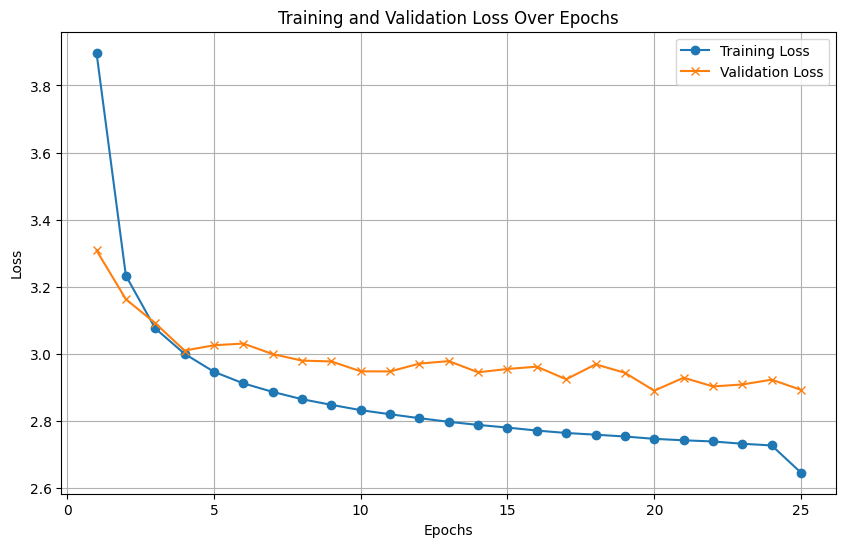

In [20]:
plot_training_losses(train_losses, val_losses)

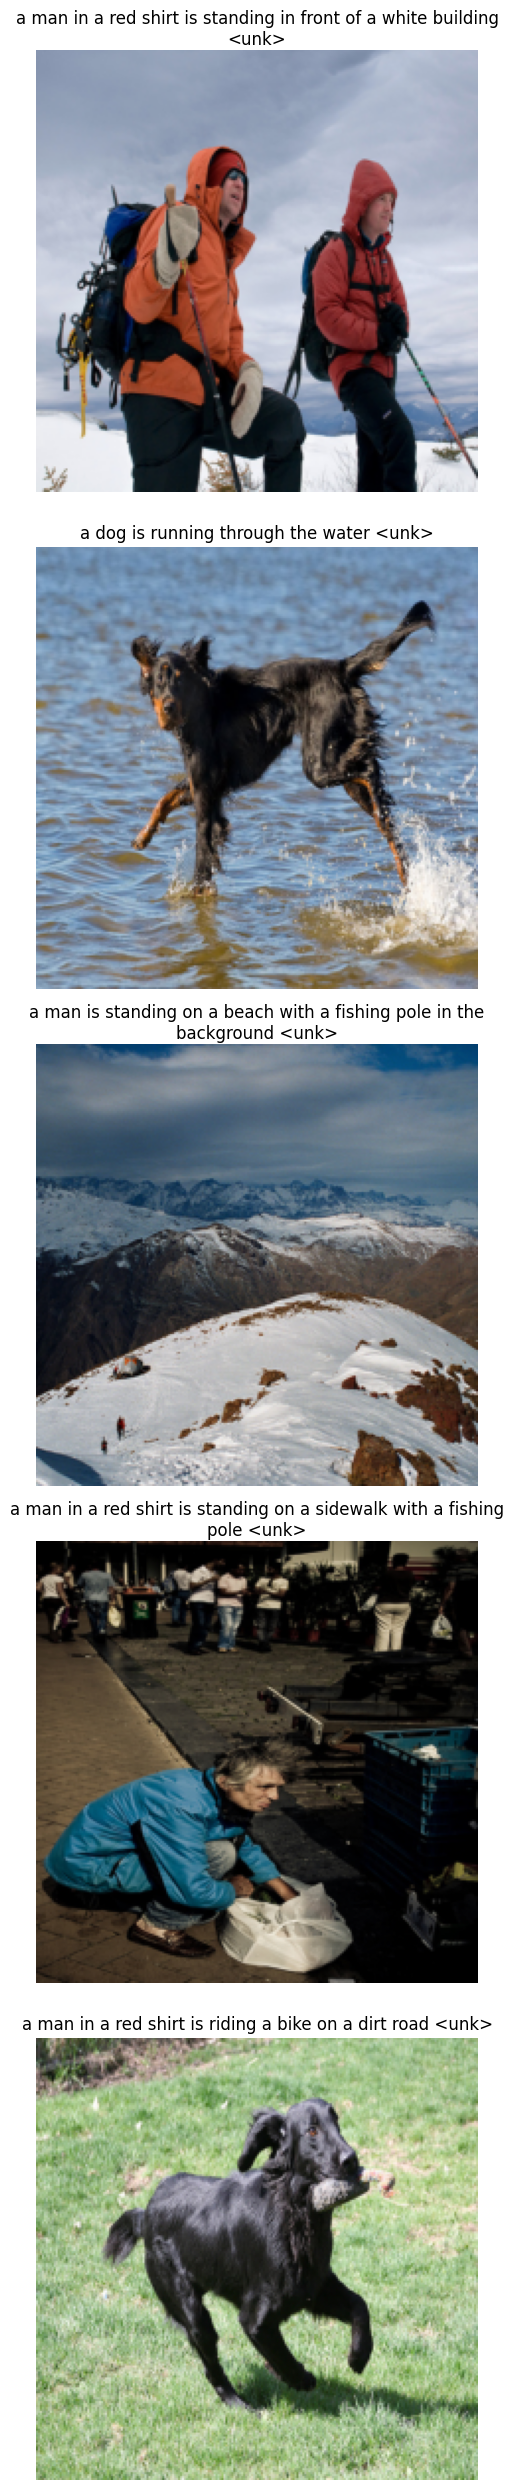

In [23]:
visualize_results(model, test_loader, word_to_index_tokenizer)